Preparing Data And Preprocessing

2025-02-21 10:23:43.680681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740113623.741866    8380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740113623.759127    8380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 10:23:43.887053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was r

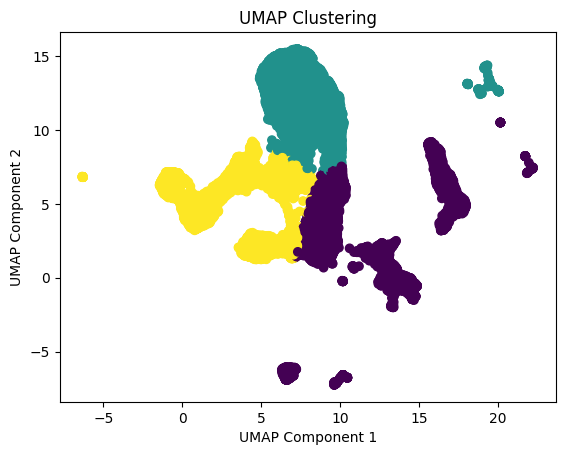

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

# ---- STEP 1: LOAD DATA ----
df = pd.read_excel('./data_files/Data_re.xlsx')  # Ensure the file exists

# ---- STEP 2: FEATURE SELECTION ----
cols_to_drop = ['object_id', 'specz_name', 'coord']  # Adjust based on dataset
features = [col for col in df.columns if col not in cols_to_drop + ['specz_redshift']]
df_selected = df[features]

# Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)
df_selected = pd.DataFrame(var_thresh.fit_transform(df_selected), 
                           columns=np.array(features)[var_thresh.get_support()])

# ---- STEP 3: REMOVE OUTLIERS ----
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_scores = lof.fit_predict(df_selected)
df_clean = df_selected[outlier_scores == 1].copy()
df_clean['specz_redshift'] = df.loc[outlier_scores == 1, 'specz_redshift'].values

# ---- STEP 4: SCALING & TRANSFORMING ----
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.drop(columns=['specz_redshift']))

# Apply Power Transformation (Yeo-Johnson for normalizing skewed data)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_scaled)

# ---- STEP 5: DIMENSIONALITY REDUCTION WITH UMAP ----
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_transformed)

# ---- STEP 6: OPTIONAL PCA FOR EXPLORATION ----
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_transformed)

# ---- STEP 7: CLUSTERING ----
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_umap)

# ---- PLOT RESULTS ----
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['Cluster'], cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clustering')
plt.show()


Clustering (DBScan, K means and Gaussian Mixture Method)

Optimal eps for DBSCAN: 0.200
Optimal k for K-Means/GMM: 4


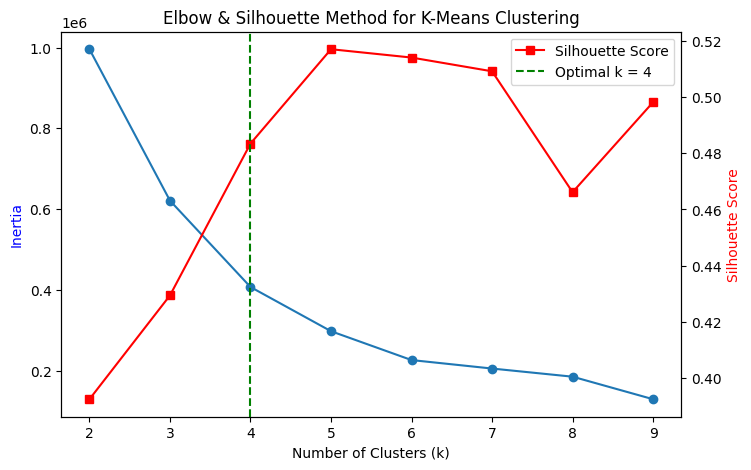

Silhouette Scores - KMeans: 0.483, GMM: 0.461, DBSCAN: -0.136


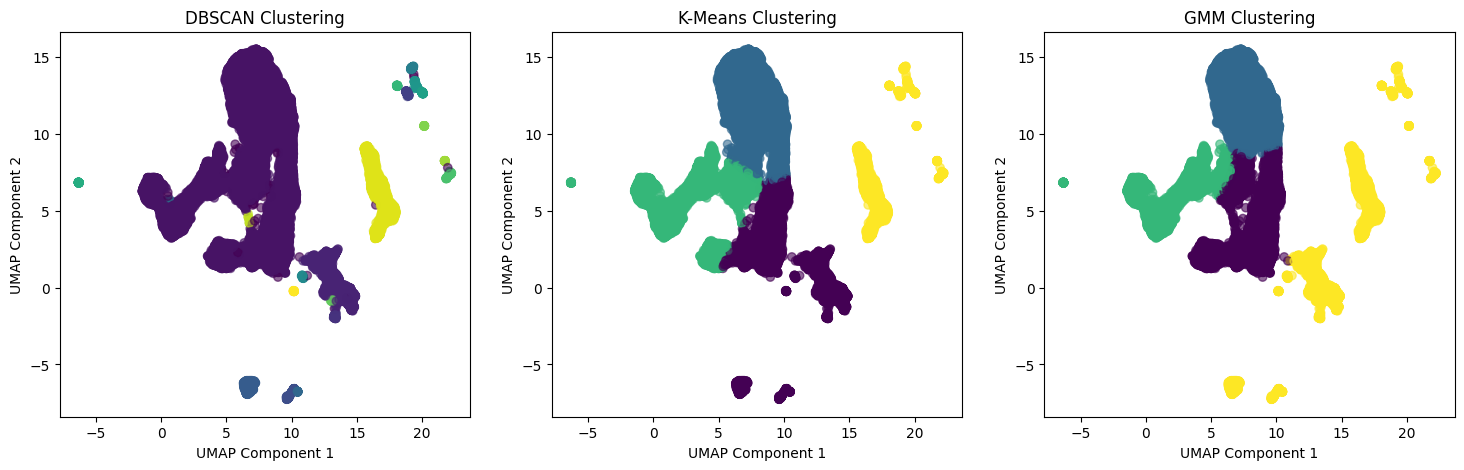

In [2]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# ---- STEP 6: DETERMINE OPTIMAL DBSCAN EPS ----
k = 5  # Typically, min_samples value
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X_umap)
distances, indices = nearest_neighbors.kneighbors(X_umap)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, -1])  # Last column gives the kth distance

# Use KneeLocator to find optimal epsilon
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.elbow]
print(f"Optimal eps for DBSCAN: {optimal_eps:.3f}")

# ---- STEP 6A: APPLY DBSCAN CLUSTERING WITH OPTIMAL EPS ----
dbscan = DBSCAN(eps=optimal_eps, min_samples=k, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(X_umap)
df_clean.loc[:, 'cluster_dbscan'] = cluster_labels_dbscan

# ---- STEP 6B: APPLY K-MEANS & GMM ----
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_umap)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)

knee_locator = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k for K-Means/GMM: {optimal_k}")

# Plot Elbow & Silhouette Scores
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(k_range, inertia, marker='o', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='blue')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', color='red', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')

plt.axvline(x=optimal_k, linestyle='--', color='green', label=f'Optimal k = {optimal_k}')
plt.title('Elbow & Silhouette Method for K-Means Clustering')
plt.legend()
plt.show()

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_clean.loc[:, 'cluster_kmeans'] = kmeans.fit_predict(X_umap)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_clean.loc[:, 'cluster_gmm'] = gmm.fit_predict(X_umap)

# ---- STEP 7: COMPUTE SILHOUETTE SCORES ----
silhouette_kmeans = silhouette_score(X_umap, df_clean['cluster_kmeans'])
silhouette_gmm = silhouette_score(X_umap, df_clean['cluster_gmm'])
silhouette_dbscan = silhouette_score(X_umap[df_clean['cluster_dbscan'] != -1], 
                                     df_clean['cluster_dbscan'][df_clean['cluster_dbscan'] != -1])

print(f"Silhouette Scores - KMeans: {silhouette_kmeans:.3f}, GMM: {silhouette_gmm:.3f}, DBSCAN: {silhouette_dbscan:.3f}")

# ---- STEP 8: VISUALIZE CLUSTERING METHODS (2D PLOTS) ----
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN 2D Plot
ax[0].scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
ax[0].set_title("DBSCAN Clustering")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

# K-Means 2D Plot
ax[1].scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.6)
ax[1].set_title("K-Means Clustering")
ax[1].set_xlabel("UMAP Component 1")
ax[1].set_ylabel("UMAP Component 2")

# GMM 2D Plot
ax[2].scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['cluster_gmm'], cmap='viridis', alpha=0.6)
ax[2].set_title("GMM Clustering")
ax[2].set_xlabel("UMAP Component 1")
ax[2].set_ylabel("UMAP Component 2")

plt.show()


Random Forest

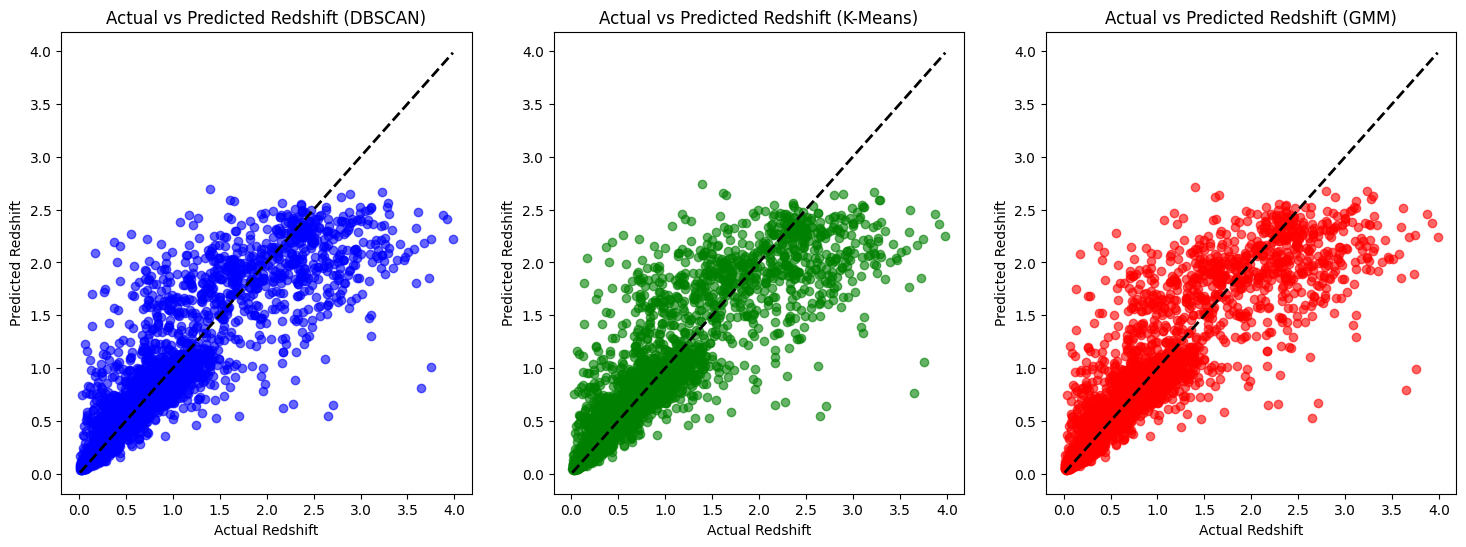

Random Forest Regression Results:
CLUSTER_DBSCAN - MSE: 0.057294, R2: 0.823465
CLUSTER_KMEANS - MSE: 0.057362, R2: 0.823254
CLUSTER_GMM - MSE: 0.057290, R2: 0.823477


In [3]:
# ---- STEP 8: RANDOM FOREST REGRESSION ----
# Train separate Random Forest models for each clustering method

results = {}

for cluster_type in ['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 9: VISUALIZE REGRESSION RESULTS ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
ax[0].scatter(y_test, results['cluster_dbscan']['y_pred'], alpha=0.6, color='blue')
ax[0].set_xlabel('Actual Redshift')
ax[0].set_ylabel('Predicted Redshift')
ax[0].set_title('Actual vs Predicted Redshift (DBSCAN)')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# K-Means
ax[1].scatter(y_test, results['cluster_kmeans']['y_pred'], alpha=0.6, color='green')
ax[1].set_xlabel('Actual Redshift')
ax[1].set_ylabel('Predicted Redshift')
ax[1].set_title('Actual vs Predicted Redshift (K-Means)')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# GMM
ax[2].scatter(y_test, results['cluster_gmm']['y_pred'], alpha=0.6, color='red')
ax[2].set_xlabel('Actual Redshift')
ax[2].set_ylabel('Predicted Redshift')
ax[2].set_title('Actual vs Predicted Redshift (GMM)')
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
print("Random Forest Regression Results:")
for cluster_type, metrics in results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


SVR and UMAP


In [4]:
# Add-Ons for Photometric Redshift Estimation 
# Fixing UMAP Import Issue and Enhancing Preprocessing

# ---- STEP 11: Install and Import UMAP Properly ----
# Ensure proper UMAP installation: pip install umap-learn
from umap import UMAP  

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(df_transformed)

# ---- STEP 12: Add More Color Indices (u-g, g-r, r-i, i-z) ----
df_clean['y_g'] = df_clean['y_flux'] - df_clean['g_flux']
df_clean['g_r'] = df_clean['g_flux'] - df_clean['r_flux']
df_clean['r_i'] = df_clean['r_flux'] - df_clean['i_flux']
df_clean['i_z'] = df_clean['i_flux'] - df_clean['z_flux']

# ---- STEP 13: Additional Clustering (HDBSCAN) for SVR Comparison ----
try:
    from hdbscan import HDBSCAN
except ImportError:
    print("HDBSCAN not installed. Use: pip install hdbscan")
    raise

hdbscan = HDBSCAN(min_cluster_size=8)
df_clean['cluster_hdbscan'] = hdbscan.fit_predict(X_umap)

# ---- STEP 14: SVR Regression for Redshift Estimation ----
from sklearn.svm import SVR
svr_results = {}

for cluster_type in ['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    svr_results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 15: Plot SVR Results ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['K-Means', 'GMM', 'HDBSCAN']
colors = ['purple', 'orange', 'cyan']

for i, cluster_type in enumerate(svr_results.keys()):
    ax[i].scatter(y_test, svr_results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_title(f'SVR Actual vs Predicted ({titles[i]})')
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- Print SVR Performance Metrics ----
print('SVR Regression Results:')
for cluster_type, metrics in svr_results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyError: 'y_flux'